<a href="https://colab.research.google.com/github/omerbokobza/DOAsAlgorithmsImpl/blob/main/RADAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MUSIC**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.linalg import svd

def music_algorithm(received_signals, num_antennas, num_sources, theta_range):
    # Calculate the covariance matrix of the received signals
    covariance_matrix = np.dot(received_signals, received_signals.conj().T) / received_signals.shape[1]

    # Eigenvalue decomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Estimate noise subspace (N = num_antennas - num_sources eigenvectors)
    noise_subspace = eigenvectors[:, num_sources:]

    # Create steering vectors for DOA candidates
    num_samples = received_signals.shape[1]
    music_spectrum = np.zeros(len(theta_range))

    for i, theta in enumerate(theta_range):
        # Steering vector for the given DOA
        a = np.exp(-1j * 2 * np.pi * np.sin(theta) * np.arange(num_antennas))

        # MUSIC spectrum calculation
        music_spectrum[i] = 1 / (np.linalg.norm(noise_subspace.conj().T @ a) ** 2)

    return music_spectrum

# Example usage:
# Define received_signals, num_antennas, num_sources, and theta_range
# music_spectrum = music_algorithm(received_signals, num_antennas, num_sources, theta_range)


In [ ]:
# def esprit_algorithm(received_signals, num_antennas, num_sources, theta_range = None):
#     # Construct the signal subspace matrix using the received signals
#     Y = np.linalg.svd(received_signals)[0][:, :num_sources]

#     # Create the difference matrix
#     Z = np.diff(Y, axis=1)

#     # Perform eigen-decomposition of Z
#     eigvals, eigvecs = np.linalg.eig(np.dot(Z, Z.conj().T))

#     # Sort eigenvalues in ascending order
#     sorted_indices = np.argsort(eigvals)
#     eigvals = eigvals[sorted_indices]
#     eigvecs = eigvecs[:, sorted_indices]

#     # Extract the phase angles from the eigenvectors
#     angles = np.angle(eigvecs)

#     # Calculate DOA estimates
#     doa_estimates = -np.angle(angles) / (2 * np.pi)

#     return doa_estimates
def esprit_algorithm(received_signals, num_antennas, num_sources, theta_range):
    # Construct the signal subspace matrix using the received signals
    Y = np.linalg.svd(received_signals)[0][:, :num_sources]

    # Create the difference matrix
    Z = np.diff(Y, axis=1)

    # Perform eigen-decomposition of Z
    eigvals, eigvecs = np.linalg.eig(np.dot(Z, Z.conj().T))

    # Sort eigenvalues in ascending order
    sorted_indices = np.argsort(eigvals)
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # Extract the phase angles from the eigenvectors
    angles = np.angle(eigvecs)

    # Calculate DOA estimates
    doa_estimates = -np.angle(angles) / (2 * np.pi)

    # Create steering vectors for DOA candidates
    num_samples = received_signals.shape[1]
    esprit_spectrum = np.zeros(len(theta_range))

    for i, theta in enumerate(theta_range):
        # Steering vector for the given DOA
        a = np.exp(-1j * 2 * np.pi * np.sin(theta) * np.arange(num_antennas))

        # Calculate the MUSIC spectrum for the current DOA
        esprit_spectrum[i] = 1 / np.linalg.norm(np.dot(a.conj().T, eigvecs))

    return esprit_spectrum


In [ ]:
def mvdr_algorithm(received_signals, num_antennas, num_sources, theta_range):
    # Calculate the covariance matrix of the received signals
    covariance_matrix = np.dot(received_signals, received_signals.conj().T) / received_signals.shape[1]
    reg_param = 1e-6
    covariance_matrix += reg_param * np.identity(num_antennas)
    # Create steering vectors for DOA candidates
    num_samples = received_signals.shape[1]
    mvdr_spectrum = np.zeros(len(theta_range))

    for i, theta in enumerate(theta_range):
        # Steering vector for the given DOA
        a = np.exp(-1j * 2 * np.pi * np.sin(theta) * np.arange(num_antennas))

        # MVDR spectrum calculation
        numerator = 1 / np.dot(a.conj().T, np.linalg.solve(covariance_matrix, a))
        mvdr_spectrum[i] = np.real(numerator)

    return mvdr_spectrum

In [ ]:
def root_music_algorithm(received_signals, num_antennas, num_sources, theta_range):
    # Calculate the signal subspace using SVD
    U, S, _ = svd(received_signals)
    signal_subspace = U[:, num_sources:]

    # Create steering vectors for DOA candidates
    num_samples = received_signals.shape[1]
    root_music_spectrum = np.zeros(len(theta_range))

    for i, theta in enumerate(theta_range):
        # Steering vector for the given DOA
        a = np.exp(-1j * 2 * np.pi * np.sin(theta) * np.arange(num_antennas))

        # Root-MUSIC spectrum calculation
        root_music_spectrum[i] = 1 / np.linalg.norm(signal_subspace.conj().T @ a)

    return root_music_spectrum

In [ ]:
def ls_algorithm(received_signals, num_antennas, num_sources, theta_range):
    # Create steering vectors for DOA candidates
    num_samples = received_signals.shape[1]
    ls_spectrum = np.zeros(len(theta_range))

    for i, theta in enumerate(theta_range):
        # Steering vector for the given DOA
        a = np.exp(-1j * 2 * np.pi * np.sin(theta) * np.arange(num_antennas))

        # Calculate LS spectrum
        a_h = a.conj().T
        numerator = np.abs(np.matmul(a_h, received_signals)) ** 2
        denominator = np.matmul(a_h, a)
        ls_spectrum[i] = np.real(numerator / denominator)[0]

    return ls_spectrum


In [ ]:
def quantize_signal(signal, num_bits):
    # Perform quantization of the signal with a specified number of bits
    quantization_levels = 2 ** num_bits
    signal_range = np.max(np.abs(signal))
    step_size = signal_range / (quantization_levels - 1)
    quantized_signal = np.round(signal / step_size) * step_size
    return quantized_signal


In [ ]:
def music_algorithm_with_quantization(received_signals, num_antennas, num_sources, theta_range, quantization_bits):
    num_samples = received_signals.shape[1]

    # Quantize the received signals (real and imaginary parts separately)
    received_signals_quantized = quantize_signal(np.real(received_signals), quantization_bits) + \
                                  1j * quantize_signal(np.imag(received_signals), quantization_bits)

    # Continue with the rest of the algorithm
    covariance_matrix = np.dot(received_signals_quantized, received_signals_quantized.conj().T) / num_samples
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Estimate noise subspace (N = num_antennas - num_sources eigenvectors)
    noise_subspace = eigenvectors[:, num_sources:]

    # Create steering vectors for DOA candidates
    music_spectrum = np.zeros(len(theta_range), dtype=float)  # Initialize as float

    for i, theta in enumerate(theta_range):
        # Steering vector for the given DOA
        a = np.exp(-1j * 2 * np.pi * np.sin(theta) * np.arange(num_antennas))
        # MUSIC spectrum calculation
        numerator = np.sum(np.abs(np.matmul(noise_subspace.conj().T, a)) ** 2)


        denominator = np.sum(np.abs(np.matmul(eigenvectors.conj().T, a)) ** 2)  # Total power
        music_spectrum[i] = 1.0 - numerator / denominator

    return music_spectrum

In [ ]:
# # Function to calculate Mean Squared Error (MSE)
def calculate_mse(true_DOAs, estimated_DOAs):
    mse_values = []
    for true_DOA in true_DOAs:
        # Find the estimated DOA that is closest to the true DOA
       closest_estimated_DOA = estimated_DOAs[np.argmin(np.abs(estimated_DOAs - true_DOA))]
       print(closest_estimated_DOA)
      #  print(true_DOA)
       mse = (true_DOA - closest_estimated_DOA) ** 2
       mse_values.append(mse)
    return np.mean(mse_values)

In [ ]:
def generate_data(num_samples, num_antennas, num_sources, signal_dim):
    # Simulate received signals with known DOAs
    received_signals = []
    true_doas = []

    for _ in range(num_samples):
        true_doa = np.sort(np.random.uniform(0, np.pi, num_sources))
        received_signal = np.zeros((num_antennas, signal_dim), dtype=complex)

        for source_idx, source_doa in enumerate(true_doa):
            array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * np.sin(source_doa))
            source_signal = np.random.randn(signal_dim) + 1j * np.random.randn(signal_dim)
            received_signal += array_response[:, np.newaxis] @ source_signal[np.newaxis, :]

        received_signals.append(received_signal)
        true_doas.append(true_doa)

    return np.array(received_signals), np.array(true_doas)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Define parameters
num_antennas = 8
num_samples = 1000
num_sources = 2
quantization_bits = 2 # Number of bits for quantization
theta_range = np.linspace(-np.pi / 2, np.pi / 2, 180)

# Define true DOAs and source amplitudes
true_DOAs = [1, -0.4, 0.5,-0.9]  # True DOA angles in radians
amplitudes = [1.2, 0.3, 0.6,1.4]  # Amplitudes of sources

# Create a uniform linear antenna array
antenna_spacing = 0.5
array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * antenna_spacing)

# Initialize arrays to store MSE results for each algorithm
mse_results = []

# # Generate received signals (original, unquantized)
np.random.seed(0)
noise = np.random.randn(num_antennas, num_samples) + 1j * np.random.randn(num_antennas, num_samples)
received_signals_original = np.zeros((num_antennas, num_samples), dtype=complex)

for i in range(num_sources):
    source_signal = amplitudes[i] * np.exp(1j * 2 * np.pi * np.sin(true_DOAs[i]) * np.arange(num_samples))
    received_signals_original += np.outer(array_response, source_signal)

# # Add noise to the received signals
noise_power = 10 ** (-10 / 10)  # Noise power (adjust SNR as needed)
received_signals_original += np.sqrt(noise_power) * noise

# Perform DOA estimation with each algorithm
estimated_DOAs_music = music_algorithm(received_signals_original, num_antennas, num_sources, theta_range)
estimated_DOAs_root_music = root_music_algorithm(received_signals_original, num_antennas, num_sources, theta_range)
estimated_DOAs_mvdr = mvdr_algorithm(received_signals_original, num_antennas, num_sources, theta_range)
estimated_DOAs_ls = ls_algorithm(received_signals_original, num_antennas, num_sources, theta_range)
estimated_DOAs_esprit = esprit_algorithm(received_signals_original, num_antennas, num_sources, theta_range)

# Quantize the received signals
received_signals_quantized = quantize_signal(received_signals_original, quantization_bits)

# Perform DOA estimation with quantized signals using each algorithm
estimated_DOAs_music_quantized = music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range)
estimated_DOAs_root_music_quantized = root_music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range)
estimated_DOAs_mvdr_quantized = mvdr_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range)
estimated_DOAs_ls_quantized = ls_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range)
estimated_DOAs_esprit_quantized = esprit_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range)

# Calculate MSE for each algorithm (quantized and unquantized)
mse_music = calculate_mse(true_DOAs, estimated_DOAs_music)
mse_root_music = calculate_mse(true_DOAs, estimated_DOAs_root_music)
mse_mvdr = calculate_mse(true_DOAs, estimated_DOAs_mvdr)
mse_ls = calculate_mse(true_DOAs, estimated_DOAs_ls)
mse_esprit = calculate_mse(true_DOAs, estimated_DOAs_esprit)

mse_music_quantized = calculate_mse(true_DOAs, estimated_DOAs_music_quantized)
mse_root_music_quantized = calculate_mse(true_DOAs, estimated_DOAs_root_music_quantized)
mse_mvdr_quantized = calculate_mse(true_DOAs, estimated_DOAs_mvdr_quantized)
mse_ls_quantized = calculate_mse(true_DOAs, estimated_DOAs_ls_quantized)
mse_esprit_quantized = calculate_mse(true_DOAs, estimated_DOAs_esprit_quantized)

# Store MSE results
mse_results.append({
    "Algorithm": "MUSIC",
    "Unquantized": mse_music,
    "Quantized": mse_music_quantized
})
mse_results.append({
    "Algorithm": "root-MUSIC",
    "Unquantized": mse_root_music,
    "Quantized": mse_root_music_quantized
})
mse_results.append({
    "Algorithm": "MVDR",
    "Unquantized": mse_mvdr,
    "Quantized": mse_mvdr_quantized
})
mse_results.append({
    "Algorithm": "LS",
    "Unquantized": mse_ls,
    "Quantized": mse_ls_quantized
})
mse_results.append({
    "Algorithm": "ESPRIT",
    "Unquantized": mse_esprit,
    "Quantized": mse_esprit_quantized
})

1.0427015990441333
0.125084784993331
0.5419690709023364
0.125084784993331
1.0211276115374162
0.35367327435548357
0.5178495883063912
0.35367327435548357
1.1239295406249288
0.023493948826496688
0.6447905223964973
0.023493948826496688
0.9913301029736549
0.0038521022420643252
0.4935190241021583
0.0038521022420643252
0.42545989662088135
0.3103242269998637
0.42545989662088135
0.3103242269998637
1.1091228955394201
0.12551300165014329
0.490625552329602
0.12551300165014329
1.0531490376672576
0.35427814164881616
0.5252552972348603
0.35427814164881616
0.8911512996209373
0.038388838121813255
0.3813415981615777
0.038388838121813255
0.9939972643745097
0.0019064460636987904
0.49941115319520657
0.0019064460636987904
0.4101878346498166
0.28803233498232417
0.4101878346498166
0.28803233498232417


In [ ]:
# Plot and compare the MSE results
plt.figure(figsize=(10, 6))
algorithm_names = [result["Algorithm"] for result in mse_results]
num_algorithms = len(algorithm_names)
print(algorithm_names)
# Width of each bar
bar_width = 0.35

# Calculate the x-axis positions for bars (quantized and unquantized)
x_unquantized = np.arange(num_algorithms)
x_quantized = x_unquantized + bar_width

# Extract the MSE values for unquantized and quantized cases
unquantized_mse_values = [result["Unquantized"] for result in mse_results]
quantized_mse_values = [result["Quantized"] for result in mse_results]

# Create bar plots for unquantized and quantized MSE values
plt.bar(x_unquantized, unquantized_mse_values, width=bar_width, label="Unquantized")
plt.bar(x_quantized, quantized_mse_values, width=bar_width, label="Quantized", alpha=0.5)

# Set x-axis labels and tick positions
# plt.xlabel("DOA Estimation Algorithm",size = 16)
plt.xticks(x_unquantized + bar_width / 2, algorithm_names, rotation=45, ha="right")
plt.xticks(fontsize=18)

# Label for the y-axis
plt.ylabel("Mean Squared Error (MSE)", size = 16)

# Title and legend
# plt.title("Comparison of DOA Estimation Algorithms (Unquantized vs. Quantized)",size = 16)
plt.legend(prop = { "size": 20 }, loc = 'best')

# Gridlines
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Final_Project/msecmp.png', bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()

['MUSIC', 'root-MUSIC', 'MVDR', 'LS', 'ESPRIT']


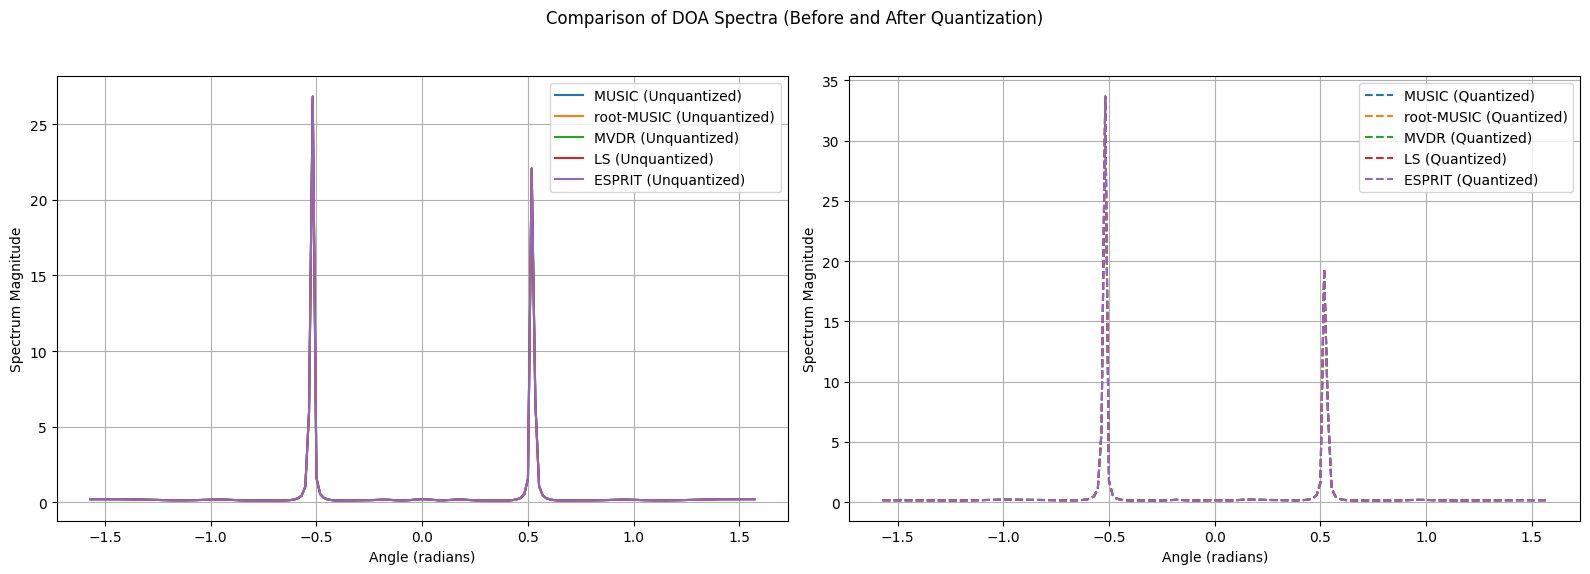

In [ ]:
# Create subplots for DOA spectra (before and after quantization)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Comparison of DOA Spectra (Before and After Quantization)")

for algorithm_name in algorithm_names:
    unquantized_spectrum = np.abs(music_algorithm(received_signals_original, num_antennas, num_sources, theta_range))
    quantized_spectrum = np.abs(music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range))

    # Subplot for unquantized signals
    axs[0].plot(theta_range, unquantized_spectrum, label=f"{algorithm_name} (Unquantized)")

    # Subplot for quantized signals
    axs[1].plot(theta_range, quantized_spectrum, label=f"{algorithm_name} (Quantized)", linestyle='--')

# Set common x and y labels
for ax in axs:
    ax.set_xlabel("Angle (radians)")
    ax.set_ylabel("Spectrum Magnitude")
    ax.grid(True)
    ax.legend()

# Adjust layout and show plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
import matplotlib
theta_range_degrees = np.degrees(theta_range)
# Create subplots for DOA spectra (original and quantized)
fig, axs = plt.subplots(2, 1, figsize=(16, 14))
# fig.suptitle("Comparison of DOA Spectra (Original vs. Quantized)",size = 20)

# Define a dictionary mapping algorithm names to their corresponding functions
algorithm_functions = {
    "MUSIC": music_algorithm,
    "root-MUSIC": root_music_algorithm,
    "MVDR": mvdr_algorithm,
    "LS": ls_algorithm,
    "ESPRIT": esprit_algorithm
}

for algorithm_name in algorithm_names:
    algorithm_function = algorithm_functions.get(algorithm_name)

    if algorithm_function is not None:
        unquantized_spectrum = np.abs(algorithm_function(received_signals_original, num_antennas, num_sources, theta_range))
        quantized_spectrum = np.abs(algorithm_function(received_signals_quantized, num_antennas, num_sources, theta_range))

        # Plot original spectra
        axs[0].plot(theta_range_degrees, unquantized_spectrum, label=f"{algorithm_name} (Original)")

        # Plot quantized spectra
        axs[1].plot(theta_range_degrees, quantized_spectrum, label=f"{algorithm_name} (Quantized)")

# Set common x and y labels with degrees
for ax in axs:
    ax.set_xlabel("Angle (degrees)", size = 20)
    ax.set_ylabel("Spectrum Magnitude", size = 20)
    ax.grid(True)
    ax.legend(prop = { "size": 20 })
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Final_Project/peaksspectrum.png', bbox_inches='tight')

# Adjust layout and show plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Final_Project/peaksspectrum.pdf', bbox_inches='tight')



1.0701931554074493
0.12657876943782737
0.5033968672578046
0.12657876943782737
1.0345014042559142
0.3557791020251553
0.49206132842238304
0.3557791020251553
2.930129708684926
2.930129708684926
2.930129708684926
2.930129708684926
0.8828832874277519
0.016149785438907823
0.4890823449239031
0.016149785438907823
0.48856429645531646
0.2957672862559127
0.48856429645531646
0.2957672862559127
1.1840878139666882
0.12662367229787314
0.5180225808817772
0.12662367229787314
1.0881579912708914
0.35584220140095135
0.4872936223049212
0.35584220140095135
1.0624414289461244
1.0624414289461244
1.0624414289461244
1.0624414289461244
1.1161672594203118
0.008048723017693054
0.49338514257069194
0.008048723017693054
0.5285316165721106
0.2264036974315857
0.4997521207290848
0.2264036974315857
1.2135786900583045
0.12678465070720502
0.5205379425532419
0.12678465070720502
1.1016254763113857
0.3560683230887106
0.4848811813534955
0.3560683230887106
1.042074167047101
0.4195108888990905
0.4991749237315672
0.41951088889909

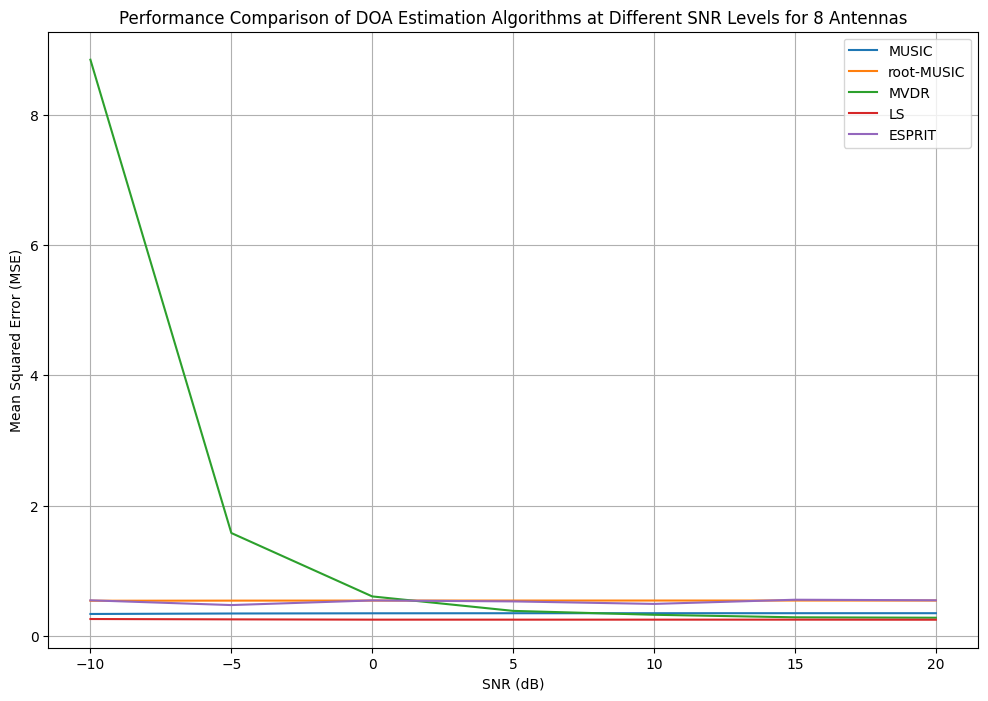

In [ ]:
# Define a range of SNR values (in dB) to test
snr_values_db = np.arange(-10, 21, 5)

# Initialize arrays to store MSE results for each algorithm at different SNR levels
mse_results_snr = {algorithm_name: [] for algorithm_name in algorithm_names}

for snr_db in snr_values_db:
    # Calculate noise power based on SNR (adjust as needed)
    noise_power = 10 ** (-snr_db / 10)

    # Generate received signals with the current SNR
    received_signals_snr = received_signals_original + np.sqrt(noise_power) * noise

    # Perform DOA estimation with each algorithm
    estimated_DOAs = {
        "MUSIC": music_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "root-MUSIC": root_music_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "MVDR": mvdr_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "LS": ls_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "ESPRIT": esprit_algorithm(received_signals_snr, num_antennas, num_sources,theta_range)
    }

    # Calculate MSE for each algorithm and store the results
    for algorithm_name, estimated_DOA in estimated_DOAs.items():
        mse = calculate_mse(true_DOAs, estimated_DOA)
        mse_results_snr[algorithm_name].append(mse)

# Create a plot to compare MSE values at different SNR levels for each algorithm
plt.figure(figsize=(12, 8))
for algorithm_name in algorithm_names:
    plt.plot(snr_values_db, mse_results_snr[algorithm_name], label=algorithm_name)

plt.xlabel("SNR (dB)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"Performance Comparison of DOA Estimation Algorithms at Different SNR Levels for {num_antennas} Antennas")
plt.legend()
plt.grid(True)
plt.show()


1.0658138754817712
0.12658282776362684
0.5070275244939445
0.12658282776362684
1.0323826206798392
0.35578480541421076
0.4935207612971811
0.35578480541421076
2.9384452479642302
2.9384452479642302
2.9384452479642302
2.9384452479642302
0.9170035082179037
0.047649184112973926
0.6310363099134139
0.047649184112973926
0.4318875363249299
0.2818145482402235
0.4318875363249299
0.2818145482402235
1.197562550520015
0.126663157843344
0.5248451978375988
0.126663157843344
1.094332011100843
0.3558976788956963
0.48893678452438616
0.3558976788956963
1.073172448317107
1.073172448317107
1.073172448317107
1.073172448317107
1.0429386080182022
0.004928036047586917
0.533740631117128
0.004928036047586917
0.45117824615445956
0.29920505610857945
0.45117824615445956
0.29920505610857945
1.2336193241248732
0.12682607582835145
0.5274079953413826
0.12682607582835145
1.1106841693860938
0.35612648852388196
0.48660829760607105
0.35612648852388196
0.9773238995574444
0.43233907855278453
0.5043595351046936
0.432339078552784

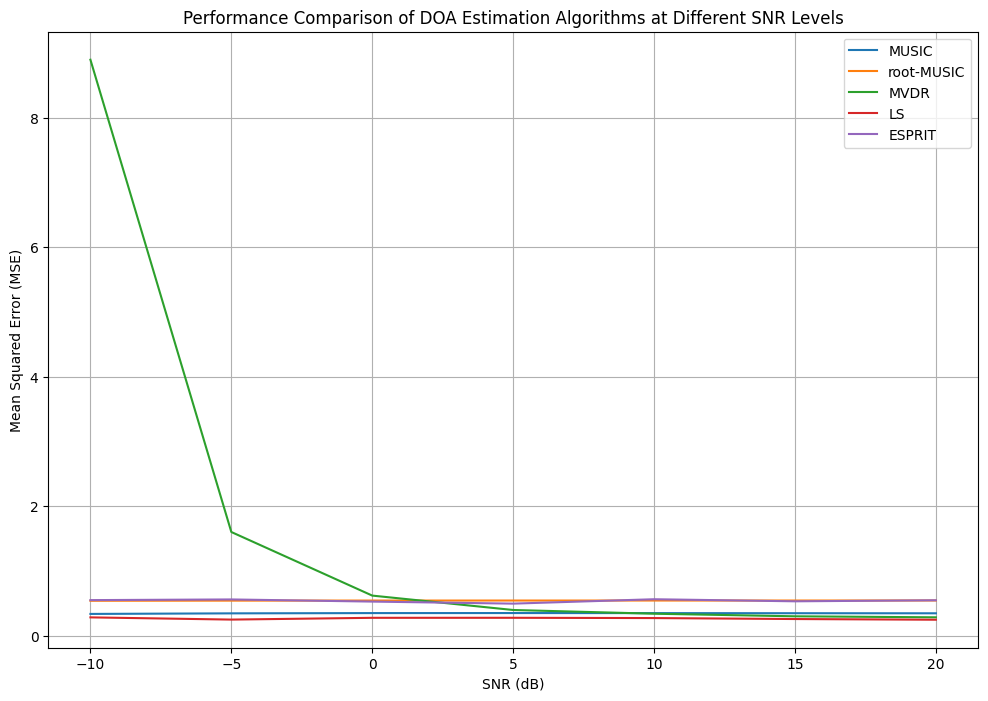

In [ ]:
# AFTER QUANTIZATION

snr_values_db = np.arange(-10, 21, 5)

# Initialize arrays to store MSE results for each algorithm at different SNR levels
mse_results_snr = {algorithm_name: [] for algorithm_name in algorithm_names}

for snr_db in snr_values_db:
    # Calculate noise power based on SNR (adjust as needed)
    noise_power = 10 ** (-snr_db / 10)

    # Generate received signals with the current SNR (quantized)
    received_signals_snr = received_signals_quantized + np.sqrt(noise_power) * noise

    # Perform DOA estimation with each algorithm (quantized)
    estimated_DOAs = {
        "MUSIC": music_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "root-MUSIC": root_music_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "MVDR": mvdr_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "LS": ls_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "ESPRIT": esprit_algorithm(received_signals_snr, num_antennas, num_sources,theta_range)
    }

    # Calculate MSE for each algorithm and store the results
    for algorithm_name, estimated_DOA in estimated_DOAs.items():
        mse = calculate_mse(true_DOAs, estimated_DOA)
        mse_results_snr[algorithm_name].append(mse)

# Create a plot to compare MSE values at different SNR levels for each algorithm
plt.figure(figsize=(12, 8))
for algorithm_name in algorithm_names:
    plt.plot(snr_values_db, mse_results_snr[algorithm_name], label=algorithm_name)

plt.xlabel("SNR (dB)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Performance Comparison of DOA Estimation Algorithms at Different SNR Levels")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# num of anntenas switch UNQUANTIZED
snr_db = 10
# Define a range of antenna counts to test
antenna_counts = np.arange(2, 33, 2)


# Initialize arrays to store MSE results for each algorithm at different antenna counts (unquantized)
mse_results_antenna_unquantized = {algorithm_name: [] for algorithm_name in algorithm_names}

for num_antennas in antenna_counts:
    # Create a uniform linear antenna array with the current number of antennas
    array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * antenna_spacing)

    # Initialize arrays to store received signals and noise for this scenario (unquantized)
    received_signals_original = np.zeros((num_antennas, num_samples), dtype=complex)
    noise = np.zeros((num_antennas, num_samples), dtype=complex)

    for i in range(num_sources):
        source_signal = amplitudes[i] * np.exp(1j * 2 * np.pi * np.sin(true_DOAs[i]) * np.arange(num_samples))
        received_signals_original += np.outer(array_response, source_signal)

    # Generate noise for this scenario (unquantized)
    noise_power = 10 ** (-snr_db / 10)
    noise = np.sqrt(noise_power) * (np.random.randn(num_antennas, num_samples) + 1j * np.random.randn(num_antennas, num_samples))

    # Calculate the covariance matrix of the received signals (unquantized)
    covariance_matrix = np.dot(received_signals_original, received_signals_original.conj().T) / num_samples

    # Eigenvalue decomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Estimate noise subspace (N = num_antennas - num_sources eigenvectors)
    noise_subspace = eigenvectors[:, num_sources:]

    # Perform DOA estimation with each algorithm (unquantized)
    estimated_DOAs_unquantized = {
        "MUSIC": music_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "root-MUSIC": root_music_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "MVDR": mvdr_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "LS": ls_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "ESPRIT": esprit_algorithm(received_signals_original, num_antennas, num_sources,theta_range)
    }

    # Calculate MSE for each algorithm and store the results (unquantized)
    for algorithm_name, estimated_DOA in estimated_DOAs_unquantized.items():
        mse = calculate_mse(true_DOAs, estimated_DOA)
        mse_results_antenna_unquantized[algorithm_name].append(mse)

# Create a plot to compare MSE values with different numbers of antennas for each algorithm (unquantized)
plt.figure(figsize=(12, 8))
for algorithm_name in algorithm_names:
    plt.plot(antenna_counts, mse_results_antenna_unquantized[algorithm_name], label=algorithm_name)

plt.xlabel("Number of Antennas",size = 18)
plt.ylabel("Mean Squared Error (MSE)",size = 18)
# plt.title(f"Performance Comparison of DOA Estimation Algorithms with Varying Number of Antennas for {num_sources} Sources (Unquantized)")
plt.legend(prop = { "size": 20 })
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Final_Project/mseantenna.png', bbox_inches='tight')

plt.show()


<ipython-input-1-14c0244498d5>:30: RuntimeWarning: divide by zero encountered in double_scalars
  music_spectrum[i] = 1 / (np.linalg.norm(noise_subspace.conj().T @ a) ** 2)
<ipython-input-4-88aefcc28cec>:15: RuntimeWarning: divide by zero encountered in double_scalars
  root_music_spectrum[i] = 1 / np.linalg.norm(signal_subspace.conj().T @ a)


inf
inf
inf
inf
inf
inf
inf
inf
0.0019646082931540883
5.000000000069923e-07
0.0019646082931540883
5.000000000069923e-07
0.9691017927497927
1.6872297554945895e-32
0.5180743585643448
1.6872297554945895e-32
0.7071067811865476
0.7071067811865475
0.7071067811865475
0.7071067811865475
1.000466785412495
0.28090908247798957
0.5185094659255484
0.28090908247798957
0.9883185427236996
0.5004335144268948
0.5004335144268948
0.5004335144268948
0.00019676812822334028
2.499999999783607e-07
0.00019676812822334028
2.499999999783607e-07
1.1282428821152415
3.37445951098918e-32
0.48144364460845496
3.37445951098918e-32
0.5505430642729862
0.45183655468043277
0.500854912954384
0.45183655468043277
1.0214887902336887
0.14693440482207787
0.5006991292561656
0.14693440482207787
0.9970793376415996
0.4082589509008303
0.4999277128226879
0.4082589509008303
5.626274990852406e-05
1.666666666504229e-07
5.6262749908530345e-05
1.666666666504229e-07
0.8783916324301934
5.06168926648377e-32
0.5180690421677392
5.06168926648377e

<ipython-input-1-14c0244498d5>:30: RuntimeWarning: divide by zero encountered in double_scalars
  music_spectrum[i] = 1 / (np.linalg.norm(noise_subspace.conj().T @ a) ** 2)
<ipython-input-4-88aefcc28cec>:15: RuntimeWarning: divide by zero encountered in double_scalars
  root_music_spectrum[i] = 1 / np.linalg.norm(signal_subspace.conj().T @ a)


inf
inf
inf
inf
0.001964608284060981
4.999999999520563e-07
0.9691017927497927
6.748919021978358e-32
[-0.  -0.5]
[-0.5 -0. ]
0.9402004054947071
0.3333355113049091
0.969639317217852
0.5773521553652584
0.00019676812806141103
2.499999999684816e-07
1.128242882115242
1.3497838043956716e-31
[-0.  -0.5 -0.  -0. ]
[-0. -0. -0. -0.]
0.7604388586286357
0.16626651525521344
1.0447899577173425
0.4167948684761755
5.626274988879125e-05
1.6666666664808812e-07
0.878391632430192
2.024675706593508e-31
[-0.  -0.  -0.  -0.  -0.  -0.5]
[-0.  -0.5 -0.5 -0.5 -0.  -0. ]
0.7616575887241508
0.14285714308479322
0.9704211656333219
0.3563762543443299
2.346557050546417e-05
1.2499999998697874e-07
0.9445050142046556
2.699567608791344e-31
[-0.  -0.  -0.  -0.5 -0.  -0.  -0.  -0.5]
[-0.5 -0.  -0.  -0.  -0.  -0.5 -0.5 -0.5]
0.9969713633785336
0.09227400403871155
0.8998153342152696
0.3191835090280501
1.1960780672139339e-05
9.999999999002106e-08
0.976484813459957
3.3744595109891817e-31
[-0.  -0.  -0.  -0.  -0.5 -0.5 -0.  -0.

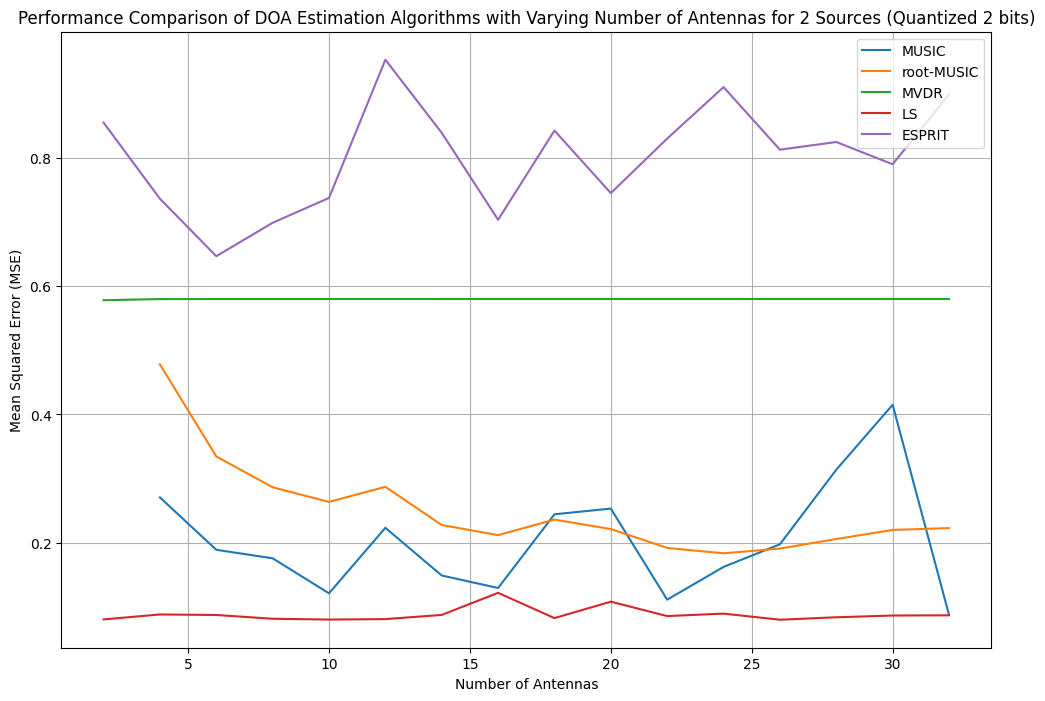

In [ ]:
# num of anntenas switch QUANTIZED
snr_db = 10
# Define a range of antenna counts to test
antenna_counts = np.arange(2, 33, 2)

# Initialize arrays to store MSE results for each algorithm at different antenna counts (quantized)
mse_results_antenna_quantized = {algorithm_name: [] for algorithm_name in algorithm_names}

for num_antennas in antenna_counts:
    # Create a uniform linear antenna array with the current number of antennas
    array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * antenna_spacing)

    # Initialize arrays to store received signals and noise for this scenario (quantized)
    received_signals_quantized = np.zeros((num_antennas, num_samples), dtype=complex)
    noise = np.zeros((num_antennas, num_samples), dtype=complex)

    for i in range(num_sources):
        source_signal = amplitudes[i] * np.exp(1j * 2 * np.pi * np.sin(true_DOAs[i]) * np.arange(num_samples))
        received_signals_quantized += np.outer(array_response, source_signal)

    # Apply quantization to the received signals (quantized)
    received_signals_quantized = quantize_signal(received_signals_quantized, quantization_bits)

    # Generate noise for this scenario (quantized)
    noise_power = 10 ** (-snr_db / 10)
    noise = np.sqrt(noise_power) * (np.random.randn(num_antennas, num_samples) + 1j * np.random.randn(num_antennas, num_samples))

    # Calculate the covariance matrix of the received signals (quantized)
    covariance_matrix = np.dot(received_signals_quantized, received_signals_quantized.conj().T) / num_samples

    # Eigenvalue decomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Estimate noise subspace (N = num_antennas - num_sources eigenvectors)
    noise_subspace = eigenvectors[:, num_sources:]

    # Perform DOA estimation with each algorithm (quantized)
    estimated_DOAs_quantized = {
        "MUSIC": music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "root-MUSIC": root_music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "MVDR": mvdr_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "LS": ls_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "ESPRIT": esprit_algorithm(received_signals_quantized, num_antennas, num_sources)
    }

    # Calculate MSE for each algorithm and store the results (quantized)
    for algorithm_name, estimated_DOA in estimated_DOAs_quantized.items():
        # print(true_DOAs)
        mse = calculate_mse(true_DOAs, estimated_DOA)
        mse_results_antenna_quantized[algorithm_name].append(mse)

# Create a plot to compare MSE values with different numbers of antennas for each algorithm (quantized)
plt.figure(figsize=(12, 8))
for algorithm_name in algorithm_names:
    plt.plot(antenna_counts, mse_results_antenna_quantized[algorithm_name], label=algorithm_name)

plt.xlabel("Number of Antennas")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"Performance Comparison of DOA Estimation Algorithms with Varying Number of Antennas for {num_sources} Sources (Quantized 2 bits)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Define a range of quantization bits to test
quantization_bits_range = np.arange(2, 13)

# Initialize arrays to store MSE results for each algorithm at different quantization bits
mse_results_quantization_bits = {algorithm_name: [] for algorithm_name in algorithm_names}

for quantization_bits in quantization_bits_range:
    # Quantize the received signals with the current number of bits
    received_signals_quantized = quantize_signal(received_signals_original, quantization_bits)

    # Perform DOA estimation with each algorithm (quantized)
    estimated_DOAs_quantized = {
        "MUSIC": music_algorithm_with_quantization(received_signals_quantized, num_antennas, num_sources, theta_range, quantization_bits=quantization_bits),
        "root-MUSIC": root_music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "MVDR": mvdr_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "LS": ls_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "ESPRIT": esprit_algorithm(received_signals_quantized, num_antennas, num_sources,theta_range)
    }

    # Calculate MSE for each algorithm and store the results
    for algorithm_name, estimated_DOA in estimated_DOAs_quantized.items():
        mse = calculate_mse(true_DOAs, estimated_DOA)
        mse_results_quantization_bits[algorithm_name].append(mse)

# Create a plot to compare MSE values at different quantization bits for each algorithm
plt.figure(figsize=(12, 8))
for algorithm_name in algorithm_names:
    plt.plot(quantization_bits_range, mse_results_quantization_bits[algorithm_name], label=algorithm_name)

plt.xlabel("Quantization Bits",size = 18)
plt.ylabel("Mean Squared Error (MSE)", size =18)
# plt.title(f"Performance Comparison of DOA Estimation Algorithms at Different Quantization Bits for {num_antennas} Antennas and {num_sources} Sources")
plt.legend(prop = { "size": 20 })
plt.grid(True)
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Final_Project/msequantize.png', bbox_inches='tight')
plt.show()


0.9316754425597422
3.107879217778553e-05
0.4721493924419198
3.107879217778553e-05
0.7382232748878407
0.1768319016720972
0.382875465098114
0.1768319016720972
3.73211114495583e-07
3.124999999720708e-08
3.73211114495583e-07
3.124999999720708e-08
1.1174648572810035
7.13963625484045e-31
0.5646174922081335
7.13963625484045e-31
0.2035001022869979
0.1521089592854807
0.2035001022869979
0.1521089592854807
0.9120040182032043
0.02092279807656361
0.6903123096562978
0.02092279807656361
0.6540685818820282
0.17679655093079438
0.3473066024251411
0.17679655093079438
3.732111103355725e-07
3.1249999997354966e-08
3.732111103355725e-07
3.1249999997354966e-08
1.1174648572810035
7.13963625484045e-31
0.5646174922081335
7.13963625484045e-31
0.20579265619488604
0.1403136049536871
0.20579265619488604
0.1403136049536871
0.933796261710413
4.255960203225495e-05
0.26484046804603945
4.255960203225495e-05
0.7178787215824668
0.17679093691399989
0.37493464098953216
0.17679093691399989
3.7321111038919993e-07
3.12499999975

0.9994850273038404
0.11501718003979847
0.5203980609101961
0.11501718003979847
1.040935462559254
0.3544100948391696
0.5040146063731503
0.3544100948391696
2.3465571187370978e-05
1.2499999998203585e-07
2.3465571187370978e-05
1.2499999998203585e-07
0.9445050142046556
6.748919021978363e-32
0.5363491760053334
6.748919021978363e-32
0.41805887547794207
0.31955718084273627
0.41805887547794207
0.31955718084273627
0.9854302936009678
0.11828573649670553
0.4784916774318261
0.11828573649670553
0.9243527581017265
0.35377710330456175
0.49585990329478524
0.35377710330456175
2.34655712300186e-05
1.2499999997495776e-07
2.34655712300186e-05
1.2499999997495776e-07
0.9445050142046556
6.748919021978363e-32
0.5363491760053334
6.748919021978363e-32
0.42356005697205057
0.30102042301545806
0.42356005697205057
0.30102042301545806
0.9609172225374892
0.10200663546267763
0.5754893053872193
0.10200663546267763
0.9967004943873518
0.3542385361835797
0.5005820679544545
0.3542385361835797
2.346557118577162e-05
1.24999999

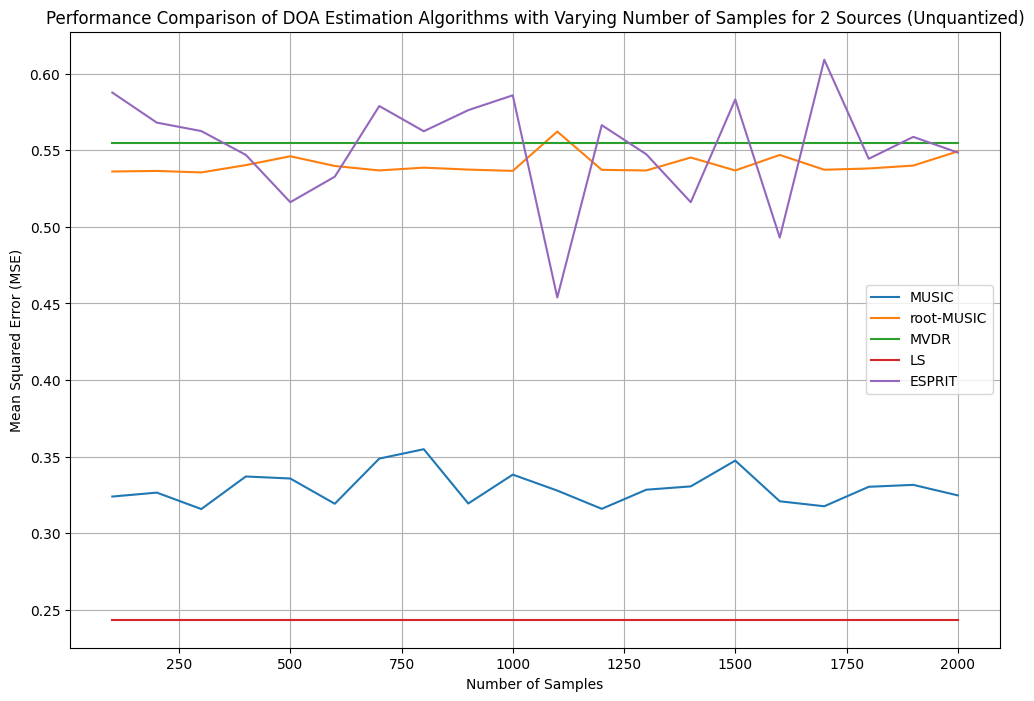

In [ ]:
# Define a range of sample counts to test
sample_counts = np.arange(100, 2001, 100)

# Initialize arrays to store MSE results for each algorithm at different sample counts (unquantized)
mse_results_sample_unquantized = {algorithm_name: [] for algorithm_name in algorithm_names}

for num_samples in sample_counts:
    # Initialize arrays to store received signals and noise for this scenario (unquantized)
    received_signals_original = np.zeros((num_antennas, num_samples), dtype=complex)
    noise = np.zeros((num_antennas, num_samples), dtype=complex)

    for i in range(num_sources):
        source_signal = amplitudes[i] * np.exp(1j * 2 * np.pi * np.sin(true_DOAs[i]) * np.arange(num_samples))
        received_signals_original += np.outer(array_response, source_signal)

    # Generate noise for this scenario (unquantized)
    noise_power = 10 ** (-snr_db / 10)
    noise = np.sqrt(noise_power) * (np.random.randn(num_antennas, num_samples) + 1j * np.random.randn(num_antennas, num_samples))

    # Calculate the covariance matrix of the received signals (unquantized)
    covariance_matrix = np.dot(received_signals_original, received_signals_original.conj().T) / num_samples

    # Eigenvalue decomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Estimate noise subspace (N = num_antennas - num_sources eigenvectors)
    noise_subspace = eigenvectors[:, num_sources:]

    # Perform DOA estimation with each algorithm (unquantized)
    estimated_DOAs_unquantized = {
        "MUSIC": music_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "root-MUSIC": root_music_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "MVDR": mvdr_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "LS": ls_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "ESPRIT": esprit_algorithm(received_signals_original, num_antennas, num_sources,theta_range)
    }

    # Calculate MSE for each algorithm and store the results (unquantized)
    for algorithm_name, estimated_DOA in estimated_DOAs_unquantized.items():
        mse = calculate_mse(true_DOAs, estimated_DOA)
        mse_results_sample_unquantized[algorithm_name].append(mse)

# Create a plot to compare MSE values with different numbers of samples for each algorithm (unquantized)
plt.figure(figsize=(12, 8))
for algorithm_name in algorithm_names:
    plt.plot(sample_counts, mse_results_sample_unquantized[algorithm_name], label=algorithm_name)

plt.xlabel("Number of Samples")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"Performance Comparison of DOA Estimation Algorithms with Varying Number of Samples for {num_sources} Sources (Unquantized)")
plt.legend()
plt.grid(True)
plt.show()



#**DOA - Deep Learning Approach**

Epoch 1/50
75/75 [==============================] - 1s 2ms/step - loss: 1.4264
Epoch 2/50
75/75 [==============================] - 0s 3ms/step - loss: 0.4474
Epoch 3/50
75/75 [==============================] - 0s 2ms/step - loss: 0.2402
Epoch 4/50
75/75 [==============================] - 0s 3ms/step - loss: 0.1332
Epoch 5/50
75/75 [==============================] - 0s 3ms/step - loss: 0.0718
Epoch 6/50
75/75 [==============================] - 0s 3ms/step - loss: 0.0377
Epoch 7/50
75/75 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 8/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 9/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 10/50
75/75 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 11/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 12/50
75/75 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 13/50
75/75 [==============================

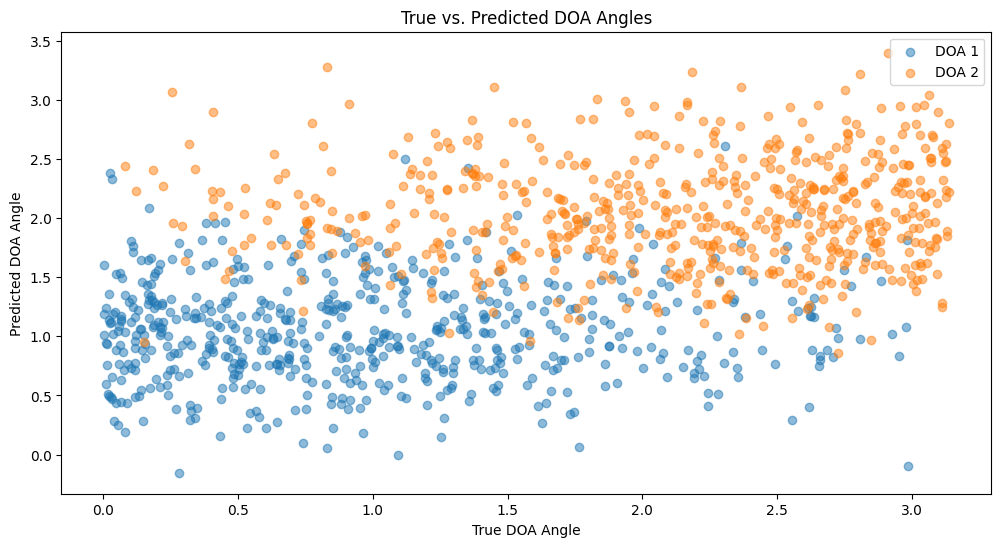

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Generate your data with the same number of samples as used for training and testing
num_samples = 3000 # Adjust the number of samples
num_antennas = 8
num_sources = 2
signal_dim = 100

received_signals, true_doas = generate_data(num_samples, num_antennas, num_sources, signal_dim)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(received_signals, true_doas, test_size=0.2, random_state=42)

# Use only the real parts of the received signals
X_train_real = np.real(X_train)
X_test_real = np.real(X_test)

# Define a function to build your neural network model
def build_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Flatten the input data
X_train_flat = X_train_real.reshape(X_train_real.shape[0], -1)
X_test_flat = X_test_real.reshape(X_test_real.shape[0], -1)

# Standardize input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Create and train the neural network model
model = build_model(X_train_scaled.shape[1], y_train.shape[1])
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate Mean Squared Error for each DOA angle
mse = mean_squared_error(y_test, y_pred)

desired_num_samples = 600  # Adjust to the number of samples you want

if true_doas.shape[0] > desired_num_samples:
    true_doas = true_doas[:desired_num_samples, :]
    y_pred = y_pred[:desired_num_samples, :]
elif true_doas.shape[0] < desired_num_samples:
    # Repeat data to match the desired number of samples
    repeat_factor = desired_num_samples // true_doas.shape[0]
    remainder_samples = desired_num_samples % true_doas.shape[0]

    true_doas = np.concatenate([true_doas] * repeat_factor, axis=0)
    y_pred = np.concatenate([y_pred] * repeat_factor, axis=0)

    # If there are remaining samples to add, take them from the beginning
    if remainder_samples > 0:
        true_doas = np.concatenate((true_doas, true_doas[:remainder_samples, :]), axis=0)
        y_pred = np.concatenate((y_pred, y_pred[:remainder_samples, :]), axis=0)

# Plot the true and predicted DOA angles
plt.figure(figsize=(12, 6))
plt.scatter(true_doas[:, 0], y_pred[:, 0], label='DOA 1', alpha=0.5)
plt.scatter(true_doas[:, 1], y_pred[:, 1], label='DOA 2', alpha=0.5)
plt.xlabel('True DOA Angle')
plt.ylabel('Predicted DOA Angle')
plt.legend()
plt.title('True vs. Predicted DOA Angles')
plt.show()


19/19 [==============================] - 0s 3ms/step


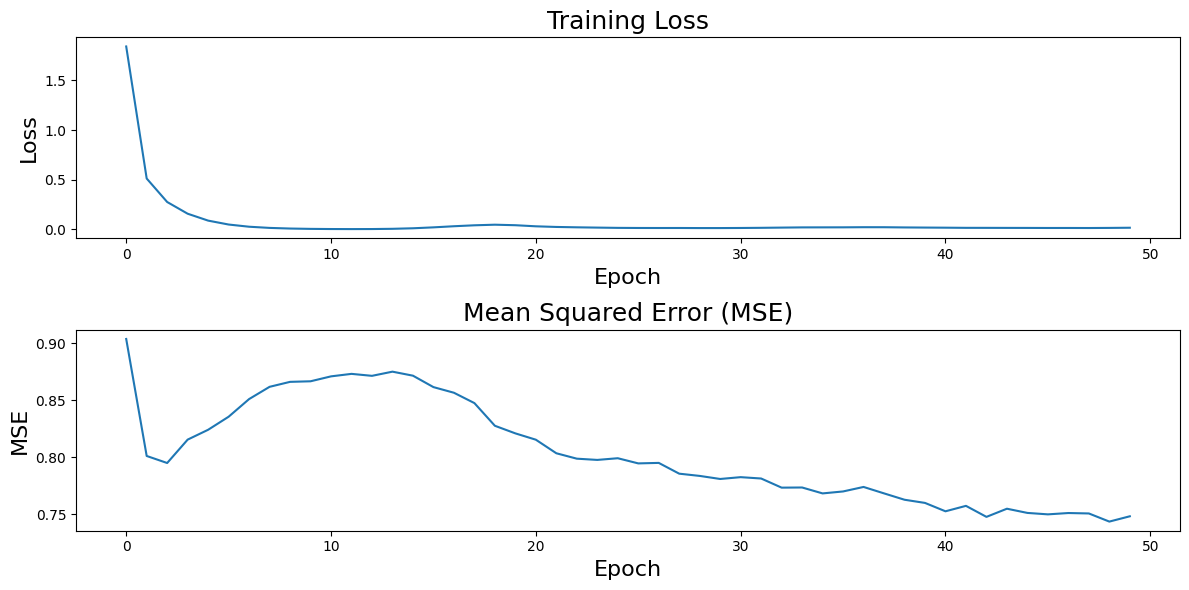

In [ ]:
model = build_model(X_train_scaled.shape[1], y_train.shape[1])

# Create lists to store loss and MSE during training
loss_history = []
mse_history = []

for epoch in range(50):  # Train for 50 epochs
    history = model.fit(X_train_scaled, y_train, epochs=1, batch_size=32, verbose=0)  # Train for 1 epoch
    loss = history.history['loss'][0]

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate Mean Squared Error for each DOA angle
    mse = mean_squared_error(y_test, y_pred)

    # Append the loss and MSE to their respective lists
    loss_history.append(loss)
    mse_history.append(mse)

# Plot the training loss
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Training Loss', size = 18)
plt.xlabel('Epoch',size = 16)
plt.ylabel('Loss', size = 16)

# Plot the MSE
plt.subplot(2, 1, 2)
plt.plot(mse_history)
plt.title('Mean Squared Error (MSE)', size =18)
plt.xlabel('Epoch', size = 16)
plt.ylabel('MSE',size=16)

plt.tight_layout()
plt.show()

In [ ]:
 from sklearn.metrics import mean_squared_error

# Calculate MSE for neural network predictions
mse_nn = mean_squared_error(true_doas, y_pred)

In [ ]:
rmse_nn = np.sqrt(mse_nn)
rmse_music = np.sqrt(mse_music)
rmse_root_music = np.sqrt(mse_root_music)
rmse_mvdr = np.sqrt(mse_mvdr)
rmse_ls = np.sqrt(mse_ls)
rmse_esprit = np.sqrt(mse_esprit)

rmse_music_q = np.sqrt(mse_music_quantized)
rmse_root_music_q = np.sqrt(mse_root_music_quantized)
rmse_mvdr_q = np.sqrt(mse_mvdr_quantized)
rmse_ls_q = np.sqrt(mse_ls_quantized)
rmse_esprit_q = np.sqrt(mse_esprit_quantized)

print(f"RMSE for Neural Network: {rmse_nn:.4f}")
print(f"RMSE for MUSIC Algorithm: {rmse_music:.4f}")
print(f"RMSE for ROOT MUSIC Algorithm: {rmse_root_music:.4f}")
print(f"RMSE for LS Algorithm: {rmse_ls:.4f}")
print(f"RMSE for ESPRIT Algorithm: {rmse_esprit:.4f}")

print(f"RMSE for QUANTIZED MUSIC Algorithm: {rmse_music_q:.4f}")
print(f"RMSE for QUANTIZED ROOT MUSIC Algorithm: {rmse_root_music_q:.4f}")
print(f"RMSE for QUANTIZED MVDR Algorithm: {rmse_mvdr_q:.4f}")
print(f"RMSE for QUANTIZED LS Algorithm: {rmse_ls_q:.4f}")
print(f"RMSE for QUANTIZED ESPRIT Algorithm: {rmse_esprit_q:.4f}")

print(f'AND THE WINNER IS!:{min(rmse_nn,rmse_music,rmse_root_music,rmse_mvdr,rmse_ls,rmse_esprit,rmse_music_q,rmse_root_music_q,rmse_mvdr_q,rmse_ls_q,rmse_esprit_q)}')

RMSE for Neural Network: 0.8829
RMSE for MUSIC Algorithm: 0.5766
RMSE for ROOT MUSIC Algorithm: 0.7315
RMSE for LS Algorithm: 0.4950
RMSE for ESPRIT Algorithm: 0.7591
RMSE for QUANTIZED MUSIC Algorithm: 0.5788
RMSE for QUANTIZED ROOT MUSIC Algorithm: 0.7324
RMSE for QUANTIZED MVDR Algorithm: 0.5241
RMSE for QUANTIZED LS Algorithm: 0.4937
RMSE for QUANTIZED ESPRIT Algorithm: 0.7485
AND THE WINNER IS!:0.49371054485760013
